In [1]:
# import libraries
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import os
import random

In [2]:
# read dataset
PATH = '../data/names.txt'

with open(PATH, 'r', encoding='utf-8') as r:
    names = r.read().split('\n')

# shuffle dataset
index = list(range(len(names)))
random.shuffle(index)
names = [names[i] for i in index]

In [3]:
# build vocab
chars = tuple(set(''.join(names)))
int2char = dict(enumerate(chars, 1))
int2char[0] = '<PAD>'
char2int = {v: k for k, v in int2char.items()}

# encode words
names_enc = [[char2int[ch] for ch in name] for name in names]
names_enc[:5]

[[41, 28, 55, 51, 50, 55, 12, 53, 2, 28],
 [41, 50, 55, 55, 28, 38, 38],
 [13, 55, 53, 52, 38, 37, 52],
 [14, 51, 37, 52, 51, 53, 28],
 [21, 37, 55, 55, 50, 31, 2, 28]]

In [4]:
# pad features
seq_length = max([len(x) for x in names_enc])

def pad_features(names, seq_length):
    features = np.zeros((len(names), seq_length), dtype=int)    

    for i, row in enumerate(names):
        # if seq_length < len(row) then row will be trimmed (expected)        
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

features = pad_features(names_enc, seq_length)

assert len(features) == len(names_enc)
assert len(features[0]) == seq_length

features[:5]

array([[41, 28, 55, 51, 50, 55, 12, 53,  2, 28,  0,  0,  0,  0,  0],
       [41, 50, 55, 55, 28, 38, 38,  0,  0,  0,  0,  0,  0,  0,  0],
       [13, 55, 53, 52, 38, 37, 52,  0,  0,  0,  0,  0,  0,  0,  0],
       [14, 51, 37, 52, 51, 53, 28,  0,  0,  0,  0,  0,  0,  0,  0],
       [21, 37, 55, 55, 50, 31,  2, 28,  0,  0,  0,  0,  0,  0,  0]])

In [5]:
# train test split
train_size = .75     # we will use 80% of data as train set
# val_size = .5       # we will use 50% of test set as validation set

split_id = int(len(features) * train_size)
train_x, test_x = features[:split_id], features[split_id:]

# test_id = int(len(remain_x) * val_size)
# val_x, test_x = remain_x[:test_id], remain_x[test_id:]

print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
# print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (5958, 15)
Test set: (1986, 15)


In [6]:
# generate batches
batch_size = 128

trainset = TensorDataset(torch.from_numpy(train_x))
# validset = TensorDataset(torch.from_numpy(val_x))
testset = TensorDataset(torch.from_numpy(test_x))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
# validloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)

In [7]:
diter = iter(trainloader)
x = diter.next()[0]

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)

Sample batch size:  torch.Size([128, 15])
Sample batch input: 
 tensor([[ 3, 28,  2,  ...,  0,  0,  0],
        [36,  2,  2,  ...,  0,  0,  0],
        [ 3, 28, 12,  ...,  0,  0,  0],
        ...,
        [27, 37, 55,  ...,  0,  0,  0],
        [36, 12, 37,  ...,  0,  0,  0],
        [14, 53, 11,  ...,  0,  0,  0]])


In [144]:
# network architecture
class RNNNamePrediction(nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_size=32, dropout=0.2):
        super(RNNNamePrediction, self).__init__()

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # RNN layer preserved by PyTorch library
        # this layer handles RNN Cell loops
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)

        # Linear layer for output
        self.output = nn.Linear(hidden_size, vocab_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, h=None):
        # its optional to init hidden state by ourselves
        # bcs PyTorch will handle it if we don't provide it

        # map input to vector
        x = self.embedding(x)

        # compute current hidden state
        o, h = self.rnn(x, h)

        # apply dropout
        o = self.dropout(o)

        # compute output
        o = self.output(o)

        return o, h

In [145]:
# define training device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [147]:
# model hyperparamters
vocab_size = len(char2int)
emebdding_dim = 16
hidden_dim = 128
dropout=0.1

model = RNNNamePrediction(vocab_size, hidden_dim, emebdding_dim, dropout)
print(model)

RNNNamePrediction(
  (embedding): Embedding(56, 16)
  (rnn): RNN(16, 128, batch_first=True)
  (output): Linear(in_features=128, out_features=56, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [148]:
lr = 0.0001
criterion = nn.CrossEntropyLoss()
optim = Adam(model.parameters(), lr=lr)
grad_clip = 5
epochs = 1000
print_every = 100
history = {
    'train_loss': [],    
    # 'train_acc': [],
    'val_loss': [],
    # 'val_acc': [],
    'epochs': epochs
}
MODEL_PATH = '../models/namegen_RNN.pt'

In [149]:
# train loop
model = model.to(device)

# early stop trigger
es_trigger = 0
val_loss_min = torch.inf

epochloop = tqdm(range(epochs), position=0, desc='Training...', leave=True)

for e in epochloop:

    #################
    # training mode #
    #################

    model.train()

    train_loss = 0

    for feature in trainloader:
        # transform datatype
        feature = feature[0]
        feature = feature.type(torch.LongTensor)

        # move to device
        feature = feature.to(device)

        # reset optimizer
        optim.zero_grad()

        # forward pass
        out, _ = model(feature)
        pred = out[:, :-1]
        actual = feature[:, 1:]

        # compute loss
        # example:
        # input = 'maxim'
        # out     = ['m', 'a', 'x', 'i']
        # feature = ['a', 'x', 'i', 'm']
        loss = criterion(pred.contiguous().view(-1, len(char2int)),
                         actual.contiguous().view(-1))

        # backpropagation
        loss.backward()

        # clip gradient
        nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # update optimizer
        optim.step()

        # write loss
        train_loss += loss.item()

    # write history loss
    history['train_loss'].append(train_loss/len(trainloader))

    
    ####################
    # validation model #
    ####################

    model.eval()

    val_loss = 0

    with torch.no_grad():
        for feature in testloader:
            # transform datatype
            feature = feature[0].type(torch.LongTensor)            

            # move to device
            feature = feature.to(device)

            # forward pass
            out, _ = model(feature)
            pred = out[:, :-1]
            actual = feature[:, 1:]

            # compute loss
            loss = criterion(pred.contiguous().view(-1, len(char2int)),
                         actual.contiguous().view(-1))

            # write loss
            val_loss += loss.item()

    # write loss history
    history['val_loss'].append(val_loss / len(testloader))

    # put back model to train mode
    model.train()

    # add epoch meta info
    epochloop.set_postfix_str(f'Val Loss: {val_loss/len(testloader):.3f}')

    # print epoch
    if (e+1) % print_every == 0 or e == 0:
        epochloop.write(f'Epoch {e+1}/{epochs} | Train Loss: {train_loss/len(trainloader):.4f} | Val Loss: {val_loss/len(testloader):.4f}')        
        epochloop.update()

        # save model if validation loss decrease
        if val_loss/len(testloader) <= val_loss_min:
            torch.save(model.state_dict(), MODEL_PATH)
            val_loss_min = val_loss / len(testloader)
            es_trigger = 0
        else:
            epochloop.write(f'[WARNING] Loss did not improving ({val_loss_min:.4f} --> {val_loss/len(testloader):.4f})')
            es_trigger += 1

        # force early stop
        if es_trigger >= 5:
            epochloop.write(f'Early stopped at Epoch-{e}')
            # update epochs history
            history['epochs'] = e+1
            break

Training...:   0%|          | 1/1000 [00:00<10:09,  1.64it/s, Val Loss: 3.286]

Epoch 1/1000 | Train Loss: 3.7642 | Val Loss: 3.2856


Training...:  10%|█         | 100/1000 [00:52<07:48,  1.92it/s, Val Loss: 0.907]

Epoch 100/1000 | Train Loss: 0.8997 | Val Loss: 0.9073


Training...:  20%|██        | 200/1000 [01:45<06:56,  1.92it/s, Val Loss: 0.848]

Epoch 200/1000 | Train Loss: 0.8342 | Val Loss: 0.8478


Training...:  30%|███       | 300/1000 [02:37<06:14,  1.87it/s, Val Loss: 0.822]

Epoch 300/1000 | Train Loss: 0.7939 | Val Loss: 0.8220


Training...:  40%|████      | 400/1000 [03:36<05:16,  1.90it/s, Val Loss: 0.809]

Epoch 400/1000 | Train Loss: 0.7665 | Val Loss: 0.8089


Training...:  50%|█████     | 500/1000 [04:28<04:23,  1.90it/s, Val Loss: 0.804]

Epoch 500/1000 | Train Loss: 0.7438 | Val Loss: 0.8035


Training...:  60%|██████    | 600/1000 [05:21<03:27,  1.93it/s, Val Loss: 0.800]

Epoch 600/1000 | Train Loss: 0.7247 | Val Loss: 0.7996


Training...:  70%|███████   | 700/1000 [06:14<02:38,  1.90it/s, Val Loss: 0.801]

Epoch 700/1000 | Train Loss: 0.7087 | Val Loss: 0.8008
[WARNING] Loss did not improving (0.7996 --> 0.8008)


Training...:  80%|████████  | 800/1000 [07:07<01:45,  1.90it/s, Val Loss: 0.800]

Epoch 800/1000 | Train Loss: 0.6960 | Val Loss: 0.8002
[WARNING] Loss did not improving (0.7996 --> 0.8002)


Training...:  90%|█████████ | 900/1000 [07:59<00:52,  1.90it/s, Val Loss: 0.803]

Epoch 900/1000 | Train Loss: 0.6859 | Val Loss: 0.8033
[WARNING] Loss did not improving (0.7996 --> 0.8033)


Training...: 100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s, Val Loss: 0.805]

Epoch 1000/1000 | Train Loss: 0.6751 | Val Loss: 0.8051
[WARNING] Loss did not improving (0.7996 --> 0.8051)


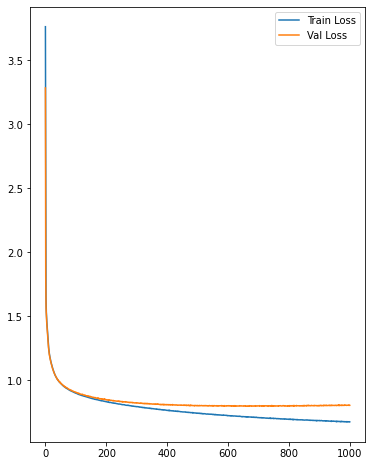

In [150]:
# plot loss
plt.figure(figsize=(6, 8))
plt.plot(range(history['epochs']), history['train_loss'], label='Train Loss')
plt.plot(range(history['epochs']), history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

In [151]:
def generate_sample(model, phrase='A', max_length=6, temperature=1.0, top_k=None):
    x_enc = [[char2int[ch] for ch in phrase]]
    # x_pad = pad_features(x_enc, max_length)
    x_torch = torch.tensor(x_enc, dtype=torch.int64)

    # create list for output
    char_out = phrase.split()

    # move to device
    x_torch = x_torch.to(device)

    # init empty hidden state
    h = None

    # running through seed phrase to generate hidden_state
    # here we leave the last character cz we will feed it in
    # the generating phase as the first sequence
    for i in range(len(phrase)-1):
        out, h = model(x_torch[:, i:i+1], h)

    # start generating
    for _ in range(max_length - len(phrase)):
        out, h = model(x_torch[:, -1:], h)
        p = F.softmax(out / temperature, dim=-1).data        

        # pick top K token by top_k (if defined)
        if top_k is None:
            top_char = np.arange(len(char2int))
        else:
            p, top_char = p.topk(top_k)
            top_char = top_char.numpy().squeeze()        

        # select next token and push it to input sequence
        p = p.numpy().squeeze()
        char_id = np.random.choice(top_char, p=p/p.sum())
        char = torch.tensor([[char_id]], dtype=torch.int64)
        x_torch = torch.cat([x_torch, char], dim=-1)
    
        # push to char_out too
        char_out.append(int2char[char_id] if char_id > 0 else ' ')

    return ''.join(char_out)

In [164]:
gen = generate_sample(model, phrase='Eu', max_length=16)
print(gen)

Euryl           


In [170]:
for i in range(10):
    gen = generate_sample(model, phrase='A', max_length=16)
    print(gen)

Alis            
Alessine        
Attoris         
Avis            
Ali             
Alena           
Adwin           
Alyse           
Anstelin        
Abe             
